# IMPORTS

In [1]:
# \\  -------- IMPORTS -------- //

from ast import Return
from codecs import getdecoder
from pkgutil import get_data
from typing import List
from unicodedata import name
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt



import backtrader as bt
import talib

# cyclical imports
from statsmodels.tsa.filters.hp_filter import hpfilter


# for outliers in data cleaning
from scipy import stats

# Data API
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

df = 0
df1 = 0

end = dt.datetime.now()  # end date is now
start = dt.datetime(1980, 1, 1)   # start date 


# IMPORTING DATA

In [2]:
# import asset data
data = yfin.download(("SPY", '^FTSE', 'DX-Y.NYB', 'CL=F', 'GBPUSD=X', 'EURUSD=X', 'AUDCHF=X', 'BTC-USD', 'SB=F'), start="2004-01-01", end= dt.datetime.now())

data_1 = pd.DataFrame(data["Close"])

# clean the data

df_asset = data_1.asfreq('D')

df_asset = df_asset.interpolate(method = 'linear') # fill gaps to the correct frequency

df_asset = df_asset.fillna(method = 'ffill')

df_asset = df_asset.fillna(method = 'backfill')

df_asset = df_asset[(np.abs(stats.zscore(df_asset)) < 10).all(axis=1)] # remove any extreme outliers

[*********************100%***********************]  9 of 9 completed


# SELECT ASSET

<class 'pandas.core.series.Series'>
DatetimeIndex: 7051 entries, 2004-01-01 to 2023-04-21
Freq: D
Series name: GBPUSD=X
Non-Null Count  Dtype  
--------------  -----  
7051 non-null   float64
dtypes: float64(1)
memory usage: 110.2 KB


<AxesSubplot:xlabel='Date'>

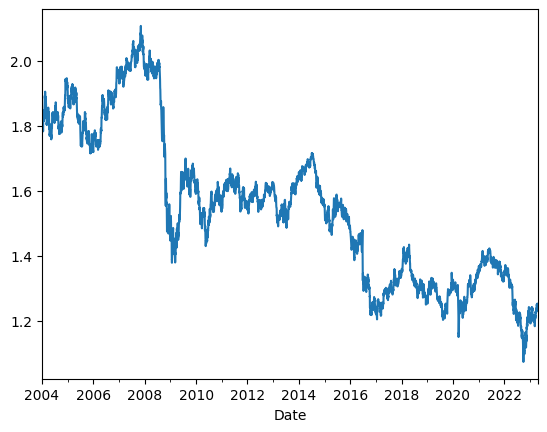

In [11]:
# select Asset
asset = 'GBPUSD=X'

df_asset[asset].info()

df_asset[asset].plot()

# Calculating Indicators

In [12]:
##########################################################################################################
# creating ROC indicators
# correlation of Weekly ROC
Fortnitely_roc = df_asset[asset].diff(periods=15)

# correlation of Monthly ROC
monthly_roc = df_asset[asset].diff(periods=30)

# correlation of Quarterly ROC
quarterly_roc = df_asset[asset].diff(periods=90)

# correlation of 6M ROC
half_year_roc = df_asset[asset].diff(periods=180)

# correlation of Yearly ROC
yearly_roc = df_asset[asset].diff(periods=365)

Rate_of_Change_data = pd.concat([Fortnitely_roc, monthly_roc, quarterly_roc, half_year_roc, yearly_roc], axis=1)

new_columns = ['Fortnitely_roc', 'Monthly_roc', 'Quarterly_roc', 'Half_year_roc', 'Yearly_roc']
Rate_of_Change_data.columns = new_columns
############################################################################################################
# Volatility Indicators

#create empty DataFrame
volatility_data = pd.DataFrame()

weekly_returns = df_asset[asset].pct_change().dropna()

Window = 15 
volatility_data['V_Fortnitely'] = weekly_returns.rolling(Window).std()
Window_2 = 30
volatility_data['V_Monthly'] = weekly_returns.rolling(Window_2).std()
Window_3 = 60
volatility_data['V_2_Monthly'] = weekly_returns.rolling(Window_3).std()
Window_4 = 90
volatility_data['V_Quarterly'] = weekly_returns.rolling(Window_4).std()
Window_5 = 180
volatility_data['V_Half_Year'] = weekly_returns.rolling(Window_5).std()
Window_6 = 365
volatility_data['V_Year'] = weekly_returns.rolling(Window_6).std()

# ALL INDICATORS IN 1 DATAFRAME

# what relationship - correlation / stationary ?
indicators_df = pd.concat([volatility_data, Rate_of_Change_data], axis=1)


# METHODS OF CHOOSING APPROPRIATE INDICATOR / INDICATORS FOR ASSET

## FINDING THE ROC INDICATOR AND VOLATILITY INDICATOR

In [13]:

# ROC INDICATOR
##############################################################################
# concat indicators with asset

asset_ind = pd.concat([Rate_of_Change_data, df_asset[asset].diff()], axis = 1)

# calculate the correlation
asset_ind_corr = asset_ind.corr()

# extract the column with the asset
corr_coeff = asset_ind_corr[asset]

#sort the values and remove the top row
corr_coeff = pd.DataFrame(corr_coeff)
corr_coeff = corr_coeff.sort_values(by = asset, ascending = False)
corr_coeff = corr_coeff.iloc[1:]

indicator_roc = corr_coeff.index[0]
print('ROC Indicator used:', indicator_roc)

# VOL INDICATOR
##############################################################################
# concat indicators with asset

asset_ind_vol = pd.concat([volatility_data, df_asset[asset].diff()], axis = 1)

# calculate the correlation
asset_ind_vol_corr = asset_ind_vol.corr()

# extract the column with the asset
corr_coeff_vol = asset_ind_vol_corr[asset]

#sort the values and remove the top row
corr_coeff_vol = pd.DataFrame(corr_coeff_vol)
corr_coeff_vol = corr_coeff_vol.sort_values(by = asset, ascending = False)
corr_coeff_vol = corr_coeff_vol.iloc[1:]
corr_coeff_vol
#print(corr_coeff_vol)
# Calculate the absolute difference from 1 and -1 for each value
abs_diff_1 = abs(corr_coeff_vol - 1)
abs_diff_minus_1 = abs(corr_coeff_vol + 1)
# Find the minimum absolute difference for each column
min_abs_diff = pd.concat([abs_diff_1.min(), abs_diff_minus_1.min()], axis=1).min(axis=1)

indicator_vol = corr_coeff_vol.index[0]
indicator_vol
print('VOL Indicator used:', indicator_vol)

ROC Indicator used: Fortnitely_roc
VOL Indicator used: V_Year


# CREATE THE RULE

## FIND THRESHOLD FOR VOLATILITY

In [14]:
#transform the data
volatility_ind = volatility_data[indicator_vol]
roc_ind = Rate_of_Change_data[indicator_roc]

# mechanism for finding data point to start at where no NaNs appear from the different rates of the indicators

# count how many nans in roc
roc_null = roc_ind.isnull().sum()
#count how many nans in volatility_data
vol_null = volatility_ind.isnull().sum()
#find the biggest an take that many rows off the start off both them

# create empty val
remove = 0
if roc_null > vol_null:
    remove = roc_null
else:
    remove = vol_null

roc_ind = roc_ind[remove:]
vol_ind = volatility_ind[remove:]
returns = df_asset[asset].diff()
returns = returns[remove + 1:]


# CHOOSE AMOUNT OF DATA WITH TAIL
# transform data
volatility_array = vol_ind.to_numpy()
# transform data
returns_array = returns.to_numpy()

### DECISION TREE FOR VOLATILITY THRESHOLD

In [15]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


n = 1000


# Split the data into training and testing sets
split_idx = int(n * 0.8)
train_returns, test_returns = returns_array[:split_idx], returns_array[split_idx:]
train_volatility, test_volatility = volatility_array[:split_idx], volatility_array[split_idx:]

# Fit decision tree to find best threshold for separating positive and negative returns
tree = DecisionTreeRegressor(max_depth=1, random_state=0)
tree.fit(train_volatility.reshape(-1, 1), train_returns)

# Extract threshold from decision tree
threshold = tree.tree_.threshold[0]

# Make predictions on test data
test_predictions = (test_volatility > threshold).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(test_returns > 0, test_predictions)
precision = precision_score(test_returns > 0, test_predictions)
recall = recall_score(test_returns > 0, test_predictions)
f1 = f1_score(test_returns > 0, test_predictions)

# Print evaluation metrics
print("Threshold for positive returns:", threshold)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Threshold for positive returns: 0.005227288696914911
Accuracy: 0.5222562011552837
Precision: 0.5166223404255319
Recall: 0.27148846960167716
F1 score: 0.3559322033898305


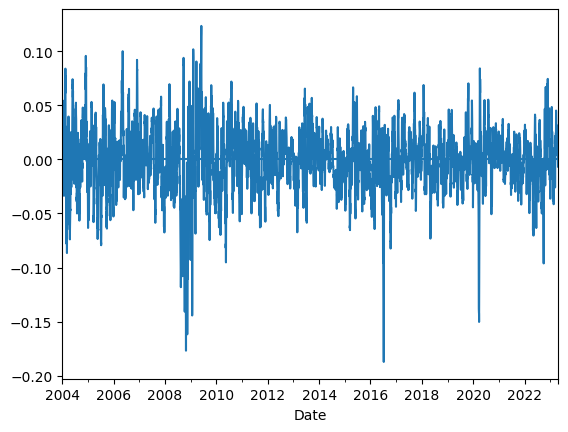

In [16]:
asset_ind[indicator_roc].plot()
plt.axhline(0)

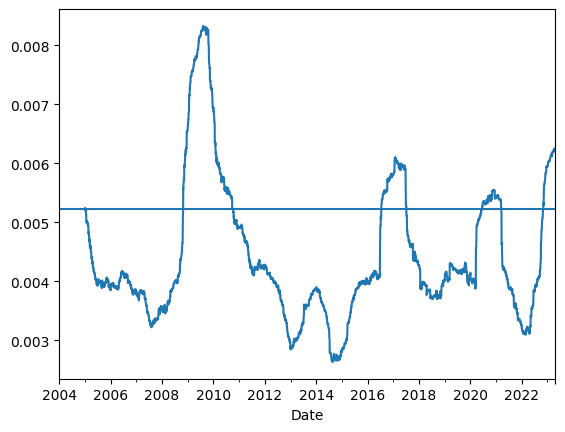

In [17]:
asset_ind_vol[indicator_vol].plot()
plt.axhline(threshold)

## INDICATOR ENVIRONMENTS

CURRENT: condition_4 ROC ↓ / VOL ↑
ROC -0.004164457321166992
VOL 0.006235817447690131


<AxesSubplot:xlabel='Date'>

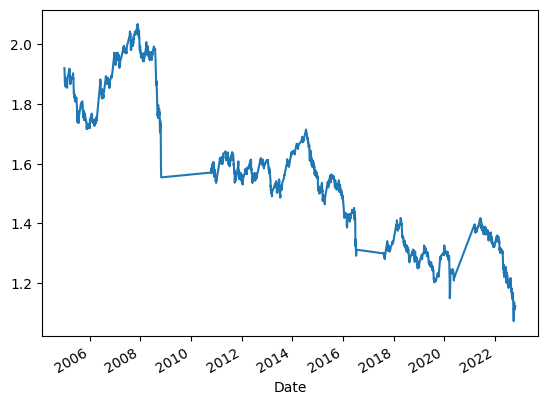

In [18]:
# THE INDICATOR RULE
# Define the rule
condition_1_data = df_asset[asset][(indicators_df[indicator_roc] > 0) & (volatility_ind < threshold)]
condition_2_data = df_asset[asset][(indicators_df[indicator_roc] > 0) & (volatility_ind > threshold)]
condition_3_data = df_asset[asset][(indicators_df[indicator_roc] < 0) & (volatility_ind < threshold)]
condition_4_data = df_asset[asset][(indicators_df[indicator_roc] < 0) & (volatility_ind > threshold)]



condition = ''

if (indicators_df[indicator_roc].tail(1).item() > 0) & (volatility_ind.tail(1).item() < threshold):
    condition = 'CURRENT: condition_1'
    print(condition, 'ROC ↑ / VOL ↓')
elif (indicators_df[indicator_roc].tail(1).item() > 0) & (volatility_ind.tail(1).item() > threshold):
    condition = 'CURRENT: condition_2'
    print(condition, 'ROC ↑ / VOL ↑')
elif (indicators_df[indicator_roc].tail(1).item() < 0) & (volatility_ind.tail(1).item() < threshold):
    condition = 'CURRENT: condition_3'
    print(condition, 'ROC ↓ / VOL ↓')
else:
    condition = 'CURRENT: condition_4'
    print(condition, 'ROC ↓ / VOL ↑')


print('ROC', indicators_df[indicator_roc].tail(1).item())
print('VOL', volatility_ind.tail(1).item())

# THE INDICATOR RULE
condition_3_data.plot() #= df_asset[asset][(indicators_df['Yearly_roc'] < -0.2)]
#sell_data.plot()

In [19]:
# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
buy_data_freq = condition_3_data.asfreq('D')
#buy_data_freq
# initialize variables
consec_counts = []
consec_count = 0
for val in buy_data_freq:
    if pd.notnull(val):
        # if value is not null, increment the count
        consec_count += 1
    else:
        # if value is null, append the current count to the list and reset the count
        if consec_count > 0:
            consec_counts.append(consec_count)
            consec_count = 0

# append the final count to the list if necessary
if consec_count > 0:
    consec_counts.append(consec_count)

# calculate the average of the consecutive counts
if len(consec_counts) > 0:
    avg_consec_count = sum(consec_counts) / len(consec_counts)
else:
    avg_consec_count = 0

# print the average number of consecutive non-null values
print(avg_consec_count)

9.694244604316546


In [20]:
# THE INDICATOR RULE
#buy_data = df_asset[asset][(indicators_df['Yearly_roc'] > -0)]

#
# CREATING THE RETURNS
cond_1_perf = ((condition_1_data - condition_1_data.shift(1)) / condition_1_data.shift(1))
cond_2_perf = ((condition_2_data - condition_2_data.shift(1)) / condition_2_data.shift(1))
cond_3_perf = ((condition_3_data - condition_3_data.shift(1)) / condition_3_data.shift(1))
cond_4_perf = ((condition_4_data - condition_4_data.shift(1)) / condition_4_data.shift(1))

# convert date column to datetime format
cond_1_perf['date'] = pd.to_datetime(cond_1_perf.index)
cond_2_perf['date'] = pd.to_datetime(cond_2_perf.index)
cond_3_perf['date'] = pd.to_datetime(cond_3_perf.index)
cond_4_perf['date'] = pd.to_datetime(cond_4_perf.index)

cond_1_perf = pd.DataFrame(cond_1_perf)
cond_2_perf = pd.DataFrame(cond_2_perf)
cond_3_perf = pd.DataFrame(cond_3_perf)
cond_4_perf = pd.DataFrame(cond_4_perf)

cond_1_perf['date'] = cond_1_perf.index
cond_2_perf['date'] = cond_2_perf.index
cond_3_perf['date'] = cond_3_perf.index
cond_4_perf['date'] = cond_4_perf.index

cond_1_perf = cond_1_perf.drop(cond_1_perf.index[-1])
cond_2_perf = cond_2_perf.drop(cond_2_perf.index[-1])
cond_3_perf = cond_3_perf.drop(cond_3_perf.index[-1])
cond_4_perf = cond_4_perf.drop(cond_4_perf.index[-1])

cond_1_perf['date'] = pd.to_datetime(cond_1_perf['date'])
cond_2_perf['date'] = pd.to_datetime(cond_2_perf['date'])
cond_3_perf['date'] = pd.to_datetime(cond_3_perf['date'])
cond_4_perf['date'] = pd.to_datetime(cond_4_perf['date'])

cond_1_perf['diff'] = (cond_1_perf['date'] - cond_1_perf['date'].shift(1)).dt.days != 1
cond_2_perf['diff'] = (cond_2_perf['date'] - cond_2_perf['date'].shift(1)).dt.days != 1
cond_3_perf['diff'] = (cond_3_perf['date'] - cond_3_perf['date'].shift(1)).dt.days != 1
cond_4_perf['diff'] = (cond_4_perf['date'] - cond_4_perf['date'].shift(1)).dt.days != 1

# filter out the rows where the diff column is True
cond_1_perf = cond_1_perf.loc[~cond_1_perf['diff'], ['date', asset]]
cond_2_perf = cond_2_perf.loc[~cond_2_perf['diff'], ['date', asset]]
cond_3_perf = cond_3_perf.loc[~cond_3_perf['diff'], ['date', asset]]
cond_4_perf = cond_4_perf.loc[~cond_4_perf['diff'], ['date', asset]]

#drop date column 
cond_1_perf = cond_1_perf.drop('date', axis = 1)
cond_2_perf = cond_2_perf.drop('date', axis = 1)
cond_3_perf = cond_3_perf.drop('date', axis = 1)
cond_4_perf = cond_4_perf.drop('date', axis = 1)

# replace with incrementing numbers so its all consecutive
cond_1_perf = cond_1_perf.reset_index(drop=True)
cond_2_perf = cond_2_perf.reset_index(drop=True)
cond_3_perf = cond_3_perf.reset_index(drop=True)
cond_4_perf = cond_4_perf.reset_index(drop=True)

# calculate avg return
cond_1_perf_avg = cond_1_perf.mean() * 100
cond_2_perf_avg = cond_2_perf.mean() * 100
cond_3_perf_avg = cond_3_perf.mean() * 100
cond_4_perf_avg = cond_4_perf.mean() * 100

#convert to float
cond_1_perf_avg = float(cond_1_perf_avg)
cond_2_perf_avg = float(cond_2_perf_avg)
cond_3_perf_avg = float(cond_3_perf_avg)
cond_4_perf_avg = float(cond_4_perf_avg)

print('CONDITION 1:', cond_1_perf_avg)
print('CONDITION 2:', cond_2_perf_avg)
print('CONDITION 3:', cond_3_perf_avg)
print('CONDITION 4:', cond_4_perf_avg)

CONDITION 1: 0.035075616365673905
CONDITION 2: 0.06491051988380185
CONDITION 3: -0.05185251933587176
CONDITION 4: -0.07373886050424944


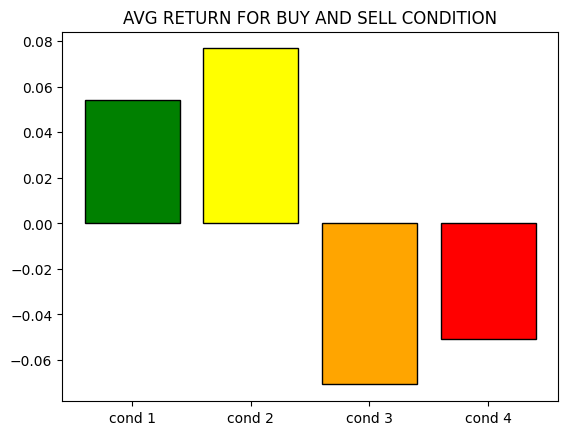

CURRENT CONDITION:  CURRENT: condition_3


In [232]:
# ASSETS PERFORMANCE IN EACH QUAD BAR CHART
# create sample data
categories = ['cond 1', 'cond 2', 'cond 3', 'cond 4']
values = [cond_1_perf_avg, cond_2_perf_avg, cond_3_perf_avg, cond_4_perf_avg]

# create the plot
plt.bar(categories, values, color=['green', 'yellow', 'orange', 'red'], edgecolor='black')

# add x-axis ticks and labels
plt.xticks(categories)

# add a title
plt.title('AVG RETURN FOR BUY AND SELL CONDITION')

# display the plot
plt.show()
print('CURRENT CONDITION: ', condition)

Sharpe Ratio: 1.0739631790636492


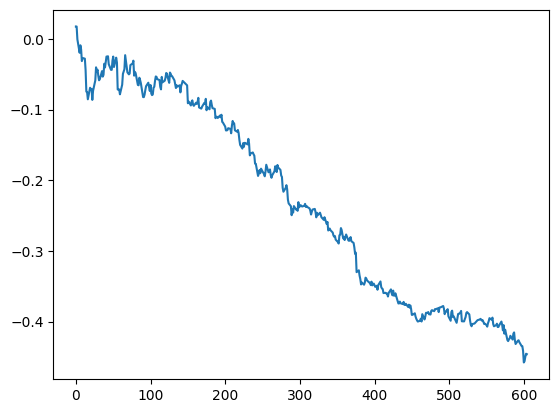

In [22]:
# EQUITY CURVE
#buy_perf.plot()

#cumulative returns
cond_1_perf['cumulative_returns'] = np.cumsum(cond_1_perf[asset])
cond_2_perf['cumulative_returns'] = np.cumsum(cond_2_perf[asset])
cond_3_perf['cumulative_returns'] = np.cumsum(cond_3_perf[asset])
cond_4_perf['cumulative_returns'] = np.cumsum(cond_4_perf[asset])

cond_4_perf['cumulative_returns'].plot()

# SHARPE RATIO
# Calculate daily returns
daily_returns = cond_4_perf['cumulative_returns'].pct_change()

# Calculate average daily return and standard deviation of daily return
avg_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()

# Calculate Sharpe Ratio
sharpe_ratio = np.sqrt(252) * (avg_daily_return / std_daily_return)

print("Sharpe Ratio:", sharpe_ratio)

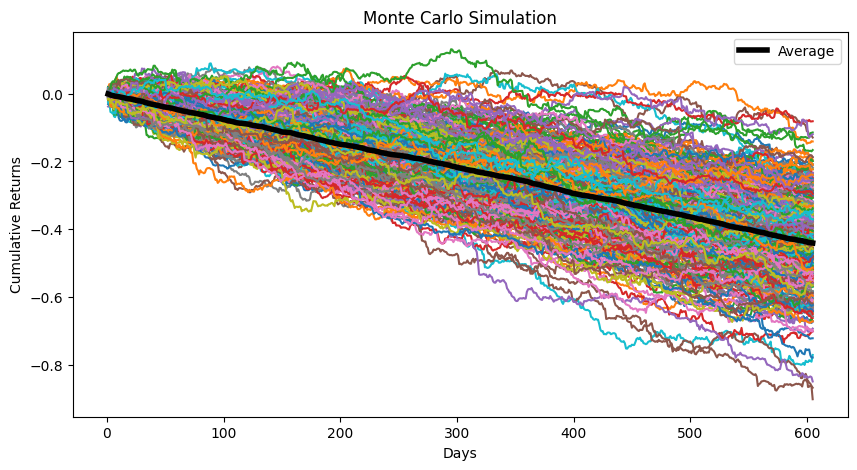

Total Trades: 605
Number of Simulations: 300
End Performance (mean): -0.44
End Performance (max): -0.08
End Performance (min): -0.90
Win Rate (mean): 44.10%
Win Rate (max): 50.91%
Win Rate (min): 38.18%
avg return at 30 days: 0.00%
avg return at 90 days: 0.02%


In [23]:
# MONTE CARLO TEST

# function to calculate drawdowns in percentage terms
def calculate_drawdowns_pct(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# monte carlo performance of asset curve in environment
################################
returns = cond_4_perf[asset]
#################################


# define parameters
num_simulations = 300
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)

    
    cumulative_returns = np.cumsum(sample_returns)

    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumsum(returns_30_days)
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumsum(returns_90_days)
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate drawdowns for each simulation
simulated_drawdowns = np.apply_along_axis(calculate_drawdowns_pct, 1, simulated_returns)

# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print(f"Total Trades: {trades_per_simulation}")
print(f"Number of Simulations: {num_simulations}")
print(f"End Performance (mean): {np.mean(end_performance):.2f}")
print(f"End Performance (max): {np.max(end_performance):.2f}")
print(f"End Performance (min): {np.min(end_performance):.2f}")
print(f"Win Rate (mean): {np.mean(win_rates)*100:.2f}%")
print(f"Win Rate (max): {np.max(win_rates)*100:.2f}%")
print(f"Win Rate (min): {np.min(win_rates)*100:.2f}%")
print(f"avg return at 30 days: {avg_cumulative_return_30_days:.2f}%")
print(f"avg return at 90 days: {avg_cumulative_return_90_days:.2f}%")


# CYCLICAL INDICATOR

## BUILD THE CYCLE MODEL

Vol Threshold limit 135.40549891662462


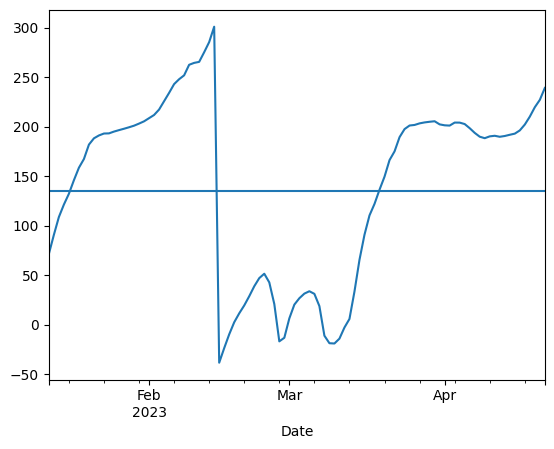

In [24]:
import talib

prices = []

prices = df_asset[asset]

prices = pd.DataFrame(prices)

prices['log_return'] = df_asset[asset].apply(np.log).diff()
#.apply(np.log)
#The first step is to find the dominant phase of the time series using the Hilbert Transform, then use it to model a cycle inefficiency in the market.

#Next is the dominant cycle period which is a signal processing technique that isolates the most significant patterns in prices.

# Hilbert Transform - Dominant Cycle Phase
prices["phase"] = talib.HT_DCPHASE(prices[asset])

#threshold for buy and sell rule
median_phase = prices['phase'].median()
print('Vol Threshold limit', median_phase)

prices['phase'].tail(100).plot()
plt.axhline(median_phase)

### INDICATOR RULES AND CURRENT CONDITION

In [25]:
cycle_buy_data = df_asset[asset][prices['phase'] < median_phase]
cycle_sell_data = df_asset[asset][prices['phase'] > median_phase]

condition_2 = ''

if prices['phase'].tail(1).item() < median_phase:
    condition_2 = 'CURRENT: condition_buy'
    print(condition_2)

else:
    condition_2 = 'CURRENT: condition_sell'
    print(condition_2)



CURRENT: condition_sell


In [26]:
# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
cycle_buy_data_freq = cycle_buy_data.asfreq('D')
cycle_sell_data_freq = cycle_sell_data.asfreq('D')

def get_avg_consec_count(cycle_data_freq):
    consec_counts = []
    consec_count = 0
    for val in cycle_data_freq:
        if pd.notnull(val):
            consec_count += 1
        else:
            if consec_count > 0:
                consec_counts.append(consec_count)
                consec_count = 0
    if consec_count > 0:
        consec_counts.append(consec_count)
    if len(consec_counts) > 0:
        return sum(consec_counts) / len(consec_counts)
    else:
        return 0

avg_consec_count_cycle_buy = get_avg_consec_count(cycle_buy_data_freq)
avg_consec_count_cycle_sell = get_avg_consec_count(cycle_sell_data_freq)

print('AVG Number of Consecutive Buy days for signal:\n', avg_consec_count_cycle_buy)
print('AVG Number of Consecutive Sell days for signal:\n', avg_consec_count_cycle_sell)


AVG Number of Consecutive Buy days for signal:
 15.881818181818181
AVG Number of Consecutive Sell days for signal:
 15.881818181818181


In [27]:
# HOW LONG IT HAS BEEN SINCE CONDITION STARTED
current_phase = prices['phase'].tail(1).item()

if current_phase < median_phase:
    condition_temp = 'buy'
else:
    condition_temp = 'sell'

if condition_temp == 'buy':
    last_sell_index = cycle_sell_data.last_valid_index()
    if pd.notnull(last_sell_index):
        last_sell_end_date = last_sell_index + pd.Timedelta(days=1)
        days_since_last_sell = (pd.Timestamp.now() - last_sell_end_date).days
        print("Current 'condition_buy' ended on:", last_sell_end_date)
        print("Days since 'condition_sell' ended:", days_since_last_sell)
else:
    last_buy_index = cycle_buy_data.last_valid_index()
    if pd.notnull(last_buy_index):
        current_buy_start_date = last_buy_index + pd.Timedelta(days=1)
        days_since_current_buy = (pd.Timestamp.today() - current_buy_start_date).days
        print("Current 'condition_sell' started on:", current_buy_start_date)
        print("Days since 'condition_buy' ended", days_since_current_buy)

Current 'condition_sell' started on: 2023-03-19 00:00:00
Days since 'condition_buy' ended 33


In [28]:
# THE INDICATOR RULE

# CREATING THE RETURNS
cyc_cond_1_perf = ((cycle_buy_data - cycle_buy_data.shift(1)) / cycle_buy_data.shift(1))
cyc_cond_2_perf = ((cycle_sell_data - cycle_sell_data.shift(1)) / cycle_sell_data.shift(1))


# convert date column to datetime format
cyc_cond_1_perf['date'] = pd.to_datetime(cyc_cond_1_perf.index)
cyc_cond_2_perf['date'] = pd.to_datetime(cyc_cond_2_perf.index)


cyc_cond_1_perf = pd.DataFrame(cyc_cond_1_perf)
cyc_cond_2_perf = pd.DataFrame(cyc_cond_2_perf)


cyc_cond_1_perf['date'] = cyc_cond_1_perf.index
cyc_cond_2_perf['date'] = cyc_cond_2_perf.index


cyc_cond_1_perf = cyc_cond_1_perf.drop(cyc_cond_1_perf.index[-1])
cyc_cond_2_perf = cyc_cond_2_perf.drop(cyc_cond_2_perf.index[-1])


cyc_cond_1_perf['date'] = pd.to_datetime(cyc_cond_1_perf['date'])
cyc_cond_2_perf['date'] = pd.to_datetime(cyc_cond_2_perf['date'])


cyc_cond_1_perf['diff'] = (cyc_cond_1_perf['date'] - cyc_cond_1_perf['date'].shift(1)).dt.days != 1
cyc_cond_2_perf['diff'] = (cyc_cond_2_perf['date'] - cyc_cond_2_perf['date'].shift(1)).dt.days != 1

# filter out the rows where the diff column is True
cyc_cond_1_perf = cyc_cond_1_perf.loc[~cyc_cond_1_perf['diff'], ['date', asset]]
cyc_cond_2_perf = cyc_cond_2_perf.loc[~cyc_cond_2_perf['diff'], ['date', asset]]


#drop date column 
cyc_cond_1_perf = cyc_cond_1_perf.drop('date', axis = 1)
cyc_cond_2_perf = cyc_cond_2_perf.drop('date', axis = 1)


# replace with incrementing numbers so its all consecutive
cyc_cond_1_perf = cyc_cond_1_perf.reset_index(drop=True)
cyc_cond_2_perf = cyc_cond_2_perf.reset_index(drop=True)


# calculate avg return
cyc_cond_1_perf_avg = cyc_cond_1_perf.mean() * 100
cyc_cond_2_perf_avg = cyc_cond_2_perf.mean() * 100

#convert to float
cyc_cond_1_perf_avg = float(cyc_cond_1_perf_avg)
cyc_cond_2_perf_avg = float(cyc_cond_2_perf_avg)


print('CONDITION 1:', cyc_cond_1_perf_avg)
print('CONDITION 2:', cyc_cond_2_perf_avg)


CONDITION 1: 0.006272304805337466
CONDITION 2: -0.009777912049279984


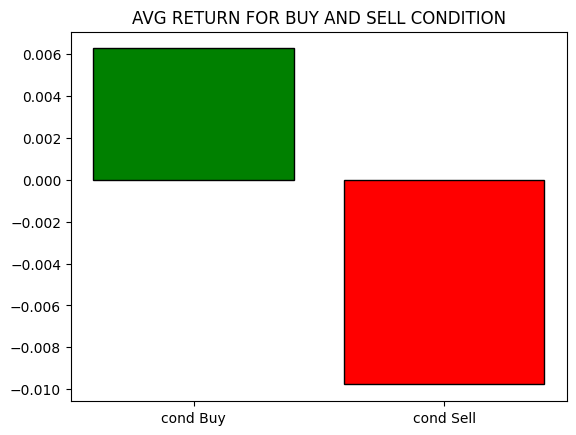

CURRENT CONDITION:  CURRENT: condition_sell


In [29]:
# ASSETS PERFORMANCE IN EACH QUAD BAR CHART
# create sample data
categories = ['cond Buy', 'cond Sell']
values = [cyc_cond_1_perf_avg, cyc_cond_2_perf_avg]

# create the plot
plt.bar(categories, values, color=['green', 'red'], edgecolor='black')

# add x-axis ticks and labels
plt.xticks(categories)

# add a title
plt.title('AVG RETURN FOR BUY AND SELL CONDITION')

# display the plot
plt.show()
print('CURRENT CONDITION: ', condition_2)

Sharpe Ratio: -0.012593207900090444
Sharpe Ratio: -0.20769109388407847


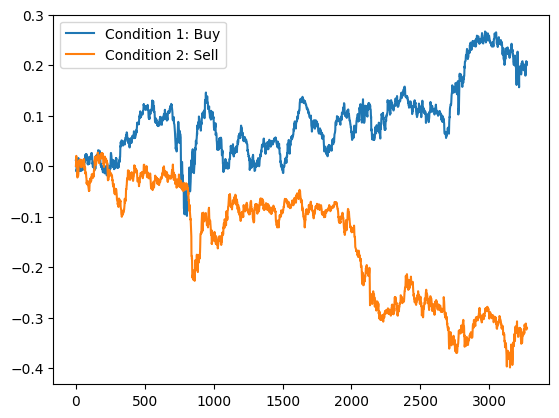

In [30]:
import matplotlib.pyplot as plt

# EQUITY CURVE
# buy_perf.plot()
#cyc_cond_1_perf = []
#cyc_cond_2_perf = []
#cyc_cond_1_perf = pd.DataFrame(cyc_cond_1_perf)
#cyc_cond_2_perf = pd.DataFrame(cyc_cond_2_perf)
# cumulative returns
cyc_cond_1_perf['cumulative_returns'] = np.cumsum(cyc_cond_1_perf[asset])
cyc_cond_2_perf['cumulative_returns'] = np.cumsum(cyc_cond_2_perf[asset])

plt.plot(cyc_cond_1_perf['cumulative_returns'], label='Condition 1: Buy')
plt.plot(cyc_cond_2_perf['cumulative_returns'], label='Condition 2: Sell')

plt.legend()  # add legend to the chart

# SHARPE RATIO
# Calculate daily returns
daily_returns = cyc_cond_1_perf['cumulative_returns'].pct_change()
daily_returns_short = -cyc_cond_2_perf['cumulative_returns'].pct_change()
# Calculate average daily return and standard deviation of daily return
avg_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()

avg_daily_return_short = daily_returns_short.mean()
std_daily_return_short = daily_returns_short.std()

# Calculate Sharpe Ratio
sharpe_ratio = np.sqrt(365) * (avg_daily_return / std_daily_return)
sharpe_ratio_short = np.sqrt(365) * (avg_daily_return_short / std_daily_return_short)

print("Sharpe Ratio:", sharpe_ratio)
print("Sharpe Ratio:", sharpe_ratio_short)



C:\Users\Christopher!\AppData\Local\Temp\ipykernel_27384\1043073648.py:6: RuntimeWarning: divide by zero encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak
C:\Users\Christopher!\AppData\Local\Temp\ipykernel_27384\1043073648.py:6: RuntimeWarning: invalid value encountered in true_divide
  drawdown = (cumulative_returns - peak) / peak


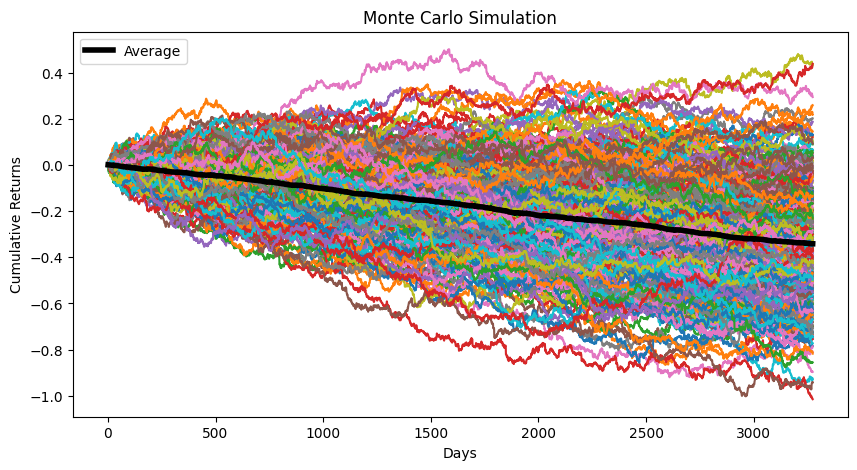

Total Trades: 3274
Number of Simulations: 300
End Performance (mean): -0.34
End Performance (max): 0.44
End Performance (min): -1.01
Win Rate (mean): 47.49%
Win Rate (max): 49.94%
Win Rate (min): 44.87%
avg return at 30 days: 0.01%
avg return at 90 days: -0.01%


In [31]:
# MONTE CARLO TEST

# function to calculate drawdowns in percentage terms
def calculate_drawdowns_pct(cumulative_returns):
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown

# monte carlo performance of asset curve in environment
################################
returns = cyc_cond_2_perf[asset]
#################################


# define parameters
num_simulations = 300
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)

    
    cumulative_returns = np.cumsum(sample_returns)

    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumsum(returns_30_days)
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumsum(returns_90_days)
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate drawdowns for each simulation
simulated_drawdowns = np.apply_along_axis(calculate_drawdowns_pct, 1, simulated_returns)

# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print(f"Total Trades: {trades_per_simulation}")
print(f"Number of Simulations: {num_simulations}")
print(f"End Performance (mean): {np.mean(end_performance):.2f}")
print(f"End Performance (max): {np.max(end_performance):.2f}")
print(f"End Performance (min): {np.min(end_performance):.2f}")
print(f"Win Rate (mean): {np.mean(win_rates)*100:.2f}%")
print(f"Win Rate (max): {np.max(win_rates)*100:.2f}%")
print(f"Win Rate (min): {np.min(win_rates)*100:.2f}%")
print(f"avg return at 30 days: {avg_cumulative_return_30_days:.2f}%")
print(f"avg return at 90 days: {avg_cumulative_return_90_days:.2f}%")


## FINAL ENVIRONMENT

In [32]:
# CONCENSUS

print('indicator condition', condition)
print('Cyclical Condition:', condition_2)
print('if both have positive return then buy')
print('if both have negative return then sell')

indicator condition CURRENT: condition_4
Cyclical Condition: CURRENT: condition_sell
if both have positive return then buy
if both have negative return then sell


## COMBINING THE TWO INDICATORS

In [239]:
# Filter the asset data based on the common dates

# changing the data structure
#indicators : roc and vol
condition_1_data_df = pd.DataFrame(condition_1_data)
condition_2_data_df = pd.DataFrame(condition_2_data)
condition_3_data_df = pd.DataFrame(condition_3_data)
condition_4_data_df = pd.DataFrame(condition_4_data)

#cyclcial indicator
cycle_buy_data_df = pd.DataFrame(cycle_buy_data)
cycle_sell_data_df = pd.DataFrame(cycle_sell_data)

# selecting the common dates between the two environments
combined_df = pd.merge(condition_4_data, cycle_sell_data, left_index=True, right_index=True)
asset_returns_combined = df_asset.loc[combined_df.index, asset]

# calculation for calculating days of signal
asset_returns_combined_df = asset_returns_combined.asfreq('D')

In [240]:
environ_1 = ((asset_returns_combined - asset_returns_combined.shift(1)) / asset_returns_combined.shift(1))


# convert date column to datetime format
environ_1['date'] = pd.to_datetime(environ_1.index)


environ_1 = pd.DataFrame(environ_1)


environ_1['date'] = environ_1.index


environ_1 = environ_1.drop(environ_1.index[-1])


environ_1['date'] = pd.to_datetime(environ_1['date'])


environ_1['diff'] = (environ_1['date'] - environ_1['date'].shift(1)).dt.days != 1


# filter out the rows where the diff column is True
environ_1 = environ_1.loc[~environ_1['diff'], ['date', asset]]


#drop date column 
environ_1 = environ_1.drop('date', axis = 1)


# replace with incrementing numbers so its all consecutive
environ_1 = environ_1.reset_index(drop=True)


# calculate avg return
environ_1_avg = environ_1.mean() * 100


#convert to float
environ_1_avg = float(environ_1_avg)


print('ENVIRONMENT DAILY AVG RETURN:', environ_1_avg)


ENVIRONMENT DAILY AVG RETURN: -0.11119926487865649


Sharpe Ratio: 1.1701744176610687


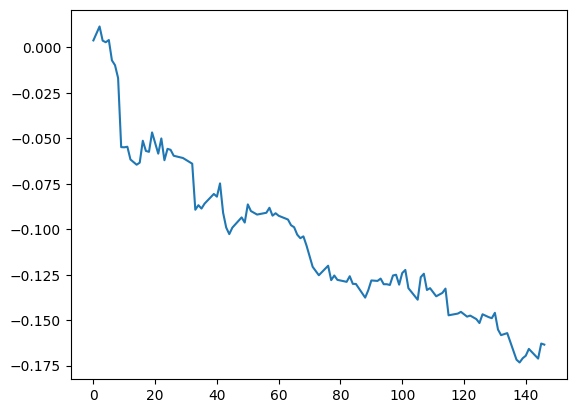

In [241]:
environ_1['cumulative_returns'] = np.cumsum(environ_1[asset])
environ_1['cumulative_returns'].plot()

# SHARPE RATIO
# Calculate daily returns
daily_returns_environ = environ_1['cumulative_returns'].pct_change()

# Calculate average daily return and standard deviation of daily return
avg_daily_returns_environ_return = daily_returns_environ.mean()
std_daily_returns_environ_return = daily_returns_environ.std()

# Calculate Sharpe Ratio
sharpe_ratio_environ = np.sqrt(365) * (avg_daily_returns_environ_return / std_daily_returns_environ_return)

print("Sharpe Ratio:", sharpe_ratio_environ)

In [242]:
import math

# AVERAGE NUMBER OF CONSECUTIVE DAYS FOR SIGNAL
environ_data_freq = asset_returns_combined.asfreq('D')
#buy_data_freq
# initialize variables
consec_counts = []
consec_count = 0

def get_avg_consec_count(environ_data_freq):
    consec_counts = []
    consec_count = 0
    for val in environ_data_freq:
        if pd.notnull(val):
            consec_count += 1
        else:
            if consec_count > 0:
                consec_counts.append(consec_count)
                consec_count = 0
    if consec_count > 0:
        consec_counts.append(consec_count)
    if len(consec_counts) > 0:
        return sum(consec_counts) / len(consec_counts)
    else:
        return 0

avg_environ_data_freq = get_avg_consec_count(environ_data_freq)

# print the average number of consecutive non-null values
print('AVG Number of Consecutive days for signal:\n', avg_environ_data_freq)

avg_signal_days = math.ceil(avg_environ_data_freq)

AVG Number of Consecutive days for signal:
 3.826923076923077


In [243]:
last_nan_date = asset_returns_combined_df.index[asset_returns_combined_df.isnull()].max()
days_since_last_nan = (end - last_nan_date).days
print('Date of environment start:', last_nan_date)
print('Days since environment start:', days_since_last_nan)

Date of environment start: 2023-04-19 00:00:00
Days since environment start: 2


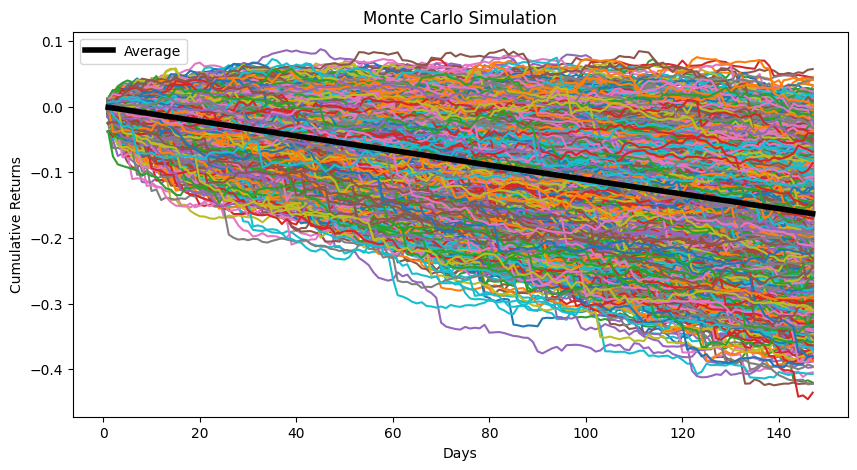

Total Trades: 147
Number of Simulations: 10000
End Performance (mean): -0.16
End Performance (max): 0.06
End Performance (min): -0.44
Win Rate (mean): 39.49%
Win Rate (max): 55.10%
Win Rate (min): 24.49%
avg return at Average Number of Signal days: -0.02%
avg return at 30 days: -0.06%
avg return at 90 days: -0.07%
Avg. Maximum Drawdown: 62.54%
Avg. Maximum Drawup: -0.61%


In [267]:
# MONTE CARLO TEST

# monte carlo performance of asset curve in environment
################################
# PUT A MINUS IN FRONT OF DF_ASSET IF THIS IS A SELL TRADE
returns = environ_1[asset]
#################################

# define parameters
num_simulations = 10000
trades_per_simulation = len(returns)
end_performance = np.zeros(num_simulations)
win_rates = np.zeros(num_simulations)
max_peak = np.zeros(num_simulations)
avg_peak = np.zeros(num_simulations)
# calculate maximum drawdown for each simulation
max_drawdowns = np.zeros(num_simulations)
opposite_max_drawdowns = np.zeros(num_simulations)

# run monte carlo simulation
simulated_returns = np.zeros((num_simulations, trades_per_simulation))
for i in range(num_simulations):
    sample_returns = returns.sample(n=trades_per_simulation, replace=True)
    cumulative_returns = np.cumsum(sample_returns)
    end_performance[i] = cumulative_returns.iloc[-1]
    win_rates[i] = np.sum(sample_returns > 0) / trades_per_simulation

    # calculate cumulative returns for average length of signal days
    returns_avg_signal_days_days = sample_returns.iloc[:avg_signal_days]
    cumulative_returns_avg_signal_days_days = np.cumsum(returns_avg_signal_days_days)
    avg_cumulative_return_avg_signal_days_days = np.mean(cumulative_returns_avg_signal_days_days)
    
    # calculate cumulative returns for 30 days
    returns_30_days = sample_returns.iloc[:30]
    cumulative_returns_30_days = np.cumsum(returns_30_days)
    avg_cumulative_return_30_days = np.mean(cumulative_returns_30_days)
    
    # calculate cumulative returns for 90 days
    returns_90_days = sample_returns.iloc[:90]
    cumulative_returns_90_days = np.cumsum(returns_90_days)
    avg_cumulative_return_90_days = np.mean(cumulative_returns_90_days)
    
    simulated_returns[i,:] = np.cumsum(sample_returns)

    # Drawdown calc 
    # #The if statement checks whether the minimum value of the simulated returns is less than the initial value (simulated_curve[0]). 
    # #If it is, then the maximum drawdown calculation is performed. 
    # #Otherwise, the max_drawdowns value for that simulation is left as zero, which will not contribute to the average calculation. 
    # #The np.nanmean function is used to calculate the mean of max_drawdowns, which will ignore any NaN values.
    simulated_curve = simulated_returns[i, :]
    if np.min(simulated_curve) < simulated_curve[0]:
        peak = np.maximum.accumulate(simulated_curve)
        drawdown = (peak - simulated_curve) / peak
        max_drawdowns[i] = np.max(drawdown)
    
    if np.max(simulated_curve) > simulated_curve[0]:
        peak = np.maximum.accumulate(simulated_curve)
        trough = np.minimum.accumulate(simulated_curve)
        peak_to_trough = -(trough - peak) / peak
        opposite_max_drawdowns[i] = np.mean(peak_to_trough)

# calculate opposite of average maximum drawdown
opposite_avg_max_drawdown = np.nanmean(opposite_max_drawdowns)

# calculate average simulation curve
mean_cumulative_returns = np.mean(simulated_returns, axis=0)

# calculate average maximum drawdown
avg_max_drawdown = np.nanmean(max_drawdowns)

# plot results
fig, ax = plt.subplots(figsize=(10,5))
for i in range(num_simulations):
    ax.plot(range(1, trades_per_simulation+1), simulated_returns[i,:])
ax.plot(range(1, trades_per_simulation+1), mean_cumulative_returns, linewidth=4, color='k', label='Average')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Monte Carlo Simulation')
ax.legend()
plt.show()

# print statistics
print(f"Total Trades: {trades_per_simulation}")
print(f"Number of Simulations: {num_simulations}")
print(f"End Performance (mean): {np.mean(end_performance):.2f}")
print(f"End Performance (max): {np.max(end_performance):.2f}")
print(f"End Performance (min): {np.min(end_performance):.2f}")
print(f"Win Rate (mean): {np.mean(win_rates)*100:.2f}%")
print(f"Win Rate (max): {np.max(win_rates)*100:.2f}%")
print(f"Win Rate (min): {np.min(win_rates)*100:.2f}%")
print(f"avg return at Average Number of Signal days: {avg_cumulative_return_avg_signal_days_days:.2f}%")
print(f"avg return at 30 days: {avg_cumulative_return_30_days:.2f}%")
print(f"avg return at 90 days: {avg_cumulative_return_90_days:.2f}%")
print(f"Avg. Maximum Drawdown: {avg_max_drawdown:.2f}%")
print(f"Avg. Maximum Drawup: {opposite_avg_max_drawdown:.2f}%")



In [271]:
# custom kelly criterion for long positions

# define variables
win_rate_long = np.mean(win_rates)
win_rate_short = -(np.mean(win_rates) - 1)
print(win_rate_short)
reward_risk_ratio_long = mean_cumulative_returns[avg_signal_days] * 100 + 1 # add 1 for positive return
reward_risk_ratio_short = mean_cumulative_returns[avg_signal_days] * 100 + 2 # add 1 for positive return
print(reward_risk_ratio_short)
account_size = 10

# calculate the expected return
expected_return_long = (win_rate_long * reward_risk_ratio_long) - ((1 - win_rate_long) * 1)
expected_return_short = (win_rate_short * reward_risk_ratio_short) - ((1 - win_rate_short) * 1)
# calculate the Kelly fraction
kelly_fraction_long = expected_return_long / reward_risk_ratio_long
kelly_fraction_short = expected_return_short / reward_risk_ratio_short
# calculate the position size
position_size_long = account_size * kelly_fraction_long
position_size_short = account_size * kelly_fraction_short

# print the optimal position size
print(f"The optimal position size for long positions is {position_size_long:.2f}%")

##################################################################################################

# print the optimal position size
print(f"The optimal position size for short positions is {position_size_short:.2f}%")


0.6050727891156462
1.4452296281991464
The optimal position size for long positions is -9.64%
The optimal position size for short positions is 3.32%


In [134]:
mean_cumulative_returns_df = pd.DataFrame(mean_cumulative_returns)
mean_cumulative_returns_df.index = pd.date_range(start=last_nan_date, periods=len(mean_cumulative_returns), freq='D')
mean_cumulative_returns_df = mean_cumulative_returns_df.reindex(pd.date_range(start=mean_cumulative_returns_df.index.min()+ dt.timedelta(days=1), end=mean_cumulative_returns_df.index.min() + dt.timedelta(days=20), freq='D')).fillna(method='ffill')

# price that day
row_number = len(df_asset[asset]) - days_since_last_nan
price_at_signal = df_asset[asset].iloc[row_number]
price_at_signal

# avg price w/ dtart of signal price
mean_cumulative_returns_df_1 = mean_cumulative_returns_df + price_at_signal



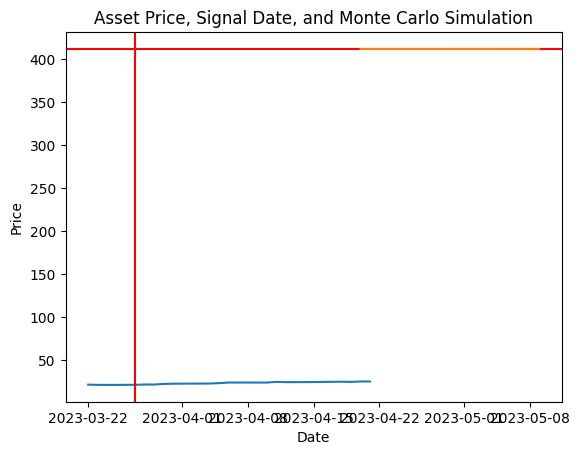

In [217]:

# THIS NEEDS FIXED TO NOT USE RETRUSN BUT ADJUST THEM TO ASSETS PRICE AGAIN TO PLOT

# create a thingy where we use the starting price of the signal that day and see where price is now from it, plus add a horizontal line where the signal price started to show relaiton of where it is now
# number of days since start of environment
#days_since_last_nan

# next day after signal
next_day = (last_nan_date + dt.timedelta(days=1))

#days_since_last_nan
days_since_last_nan_df = days_since_last_nan + 1

# Plot asset price
plt.plot(df_asset[asset].tail(days_since_last_nan + 5))

# Add horizontal line for signal price
plt.axhline(price_at_signal, color='red')

# Add vertical line for signal date
plt.axvline(next_day, color='red')

# Plot Monte Carlo simulation
plt.plot(mean_cumulative_returns_df_1)

# Set plot title and axis labels
plt.title('Asset Price, Signal Date, and Monte Carlo Simulation')
plt.xlabel('Date')
plt.ylabel('Price')

# Display plot
plt.show()